# First import all libraries that are going to be used

In [53]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


# Install kaggle API and download data from competition

In [54]:
#!pip install kaggle
#!kaggle competitions download -c el-algoritmo-es-correcto

# Read csv as pandas DataFrame

In [55]:
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')
example = pd.read_csv('example_submission.csv')

# Divide each column as dummy, float or string

In [56]:
dummy_var = ['ascensor','balcon','conjuntocerrado','cuartoservicio','deposito','estudio','gimnasio',
            'halldealcobas','parqueaderovisitantes','piscina','porteria','remodelado','saloncomunal',
            'terraza','vigilancia','vista','zonalavanderia']

float_var = ['area','banos','banoservicio','estrato','garajes','habitaciones','piso','valoradministracion',
            'valorventa']

string_var = ['tiempodeconstruido','vista','tipoinmueble','tiponegocio']

# Apply general filter. Fillna with 0's for dummy and float variables and dropna.

In [57]:
train_data[dummy_var] = train_data[dummy_var].fillna(0)
train_data['banos'] = train_data['banos'].fillna(1)
train_data['habitaciones'] = train_data['habitaciones'].fillna(1)
train_data['piso'] = train_data['piso'].fillna(1)
train_data[float_var] = train_data[float_var].fillna(0)
test_data[dummy_var] = test_data[dummy_var].fillna(0)
test_data['banos'] = test_data['banos'].fillna(1)
test_data['habitaciones'] = test_data['banos'].fillna(1)
test_data['piso'] = test_data['piso'].fillna(1)
test_data[float_var] = test_data[float_var].fillna(0)
train_data = train_data.dropna()
test_data = test_data.dropna()
train_data = train_data[train_data['tipoinmueble'] == 'Casa']

# Specific filters for float variables

In [58]:
q_up = 0.95
q_down = 0.005

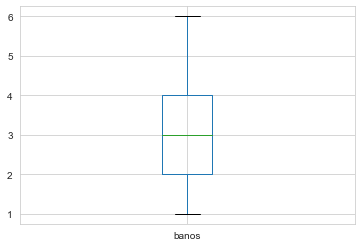

In [59]:
q_banos = train_data["banos"].quantile(q_up)
q_banos1 = train_data['banos'].quantile(q_down)
train_data = train_data[(train_data["banos"] <= q_banos) & (train_data['banos'] > 0)]
boxplot = train_data.boxplot(column=['banos'])

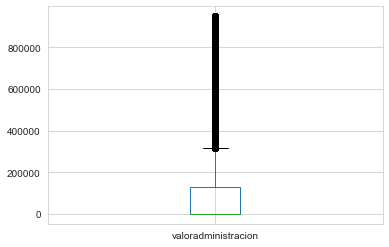

In [60]:
q_va = train_data['valoradministracion'].quantile(q_up)
train_data = train_data[train_data["valoradministracion"] <= q_va]
boxplot = train_data.boxplot(column=['valoradministracion'])

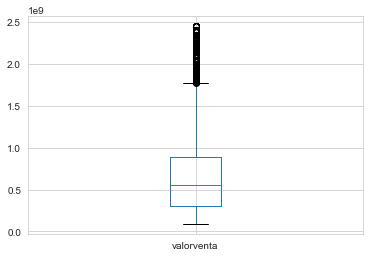

In [61]:
q_vv = train_data['valorventa'].quantile(q_up)
q_vv1 = train_data['valorventa'].quantile(q_down)
train_data = train_data[(train_data["valorventa"] <= q_vv) & (train_data['valorventa'] >= q_vv1)]
boxplot = train_data.boxplot(column=['valorventa'])

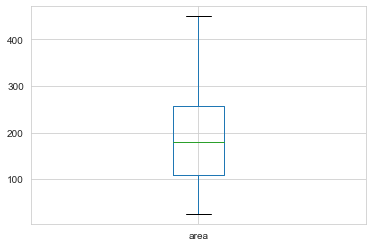

In [62]:
q_a = train_data['area'].quantile(q_up)
q_a1 = train_data['area'].quantile(q_down)
train_data = train_data[(train_data["area"] <= q_a) & (train_data['area'] >= q_a1)]
boxplot = train_data.boxplot(column=['area'])

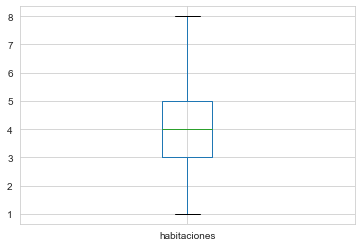

In [63]:
q_h = train_data['habitaciones'].quantile(q_up)
q_h1 = train_data['habitaciones'].quantile(q_down)
train_data = train_data[(train_data["habitaciones"] <= q_h) & (train_data['habitaciones'] >= q_h1)]
boxplot = train_data.boxplot(column=['habitaciones'])

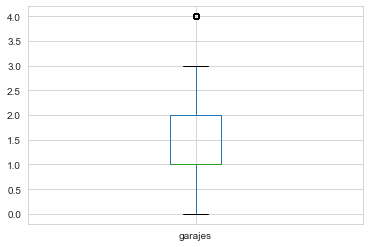

In [64]:
q_g = train_data['garajes'].quantile(q_up)
train_data = train_data[train_data["garajes"] <= q_g]
boxplot = train_data.boxplot(column=['garajes'])

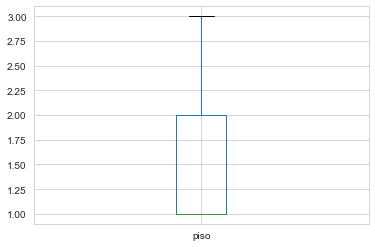

In [65]:
q_p = train_data['piso'].quantile(q_up)
train_data = train_data[train_data["piso"] <= q_p]
boxplot = train_data.boxplot(column=['piso'])

C:\Users\piper\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


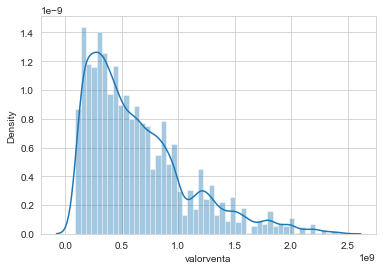

C:\Users\piper\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


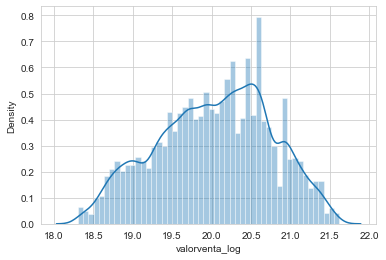

In [66]:
hist_vv = train_data['valorventa']
sn.set_style("whitegrid")
sn.distplot(hist_vv)
plt.show()

train_data["valorventa_log"] = np.log(train_data['valorventa'])
hist_vvlog = train_data['valorventa_log']
sn.distplot(hist_vvlog)
plt.show()

test_data['valorventa_log'] = np.log(test_data['valorventa'])

C:\Users\piper\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


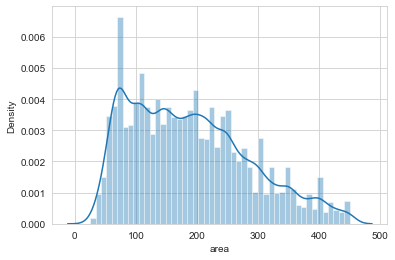

C:\Users\piper\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


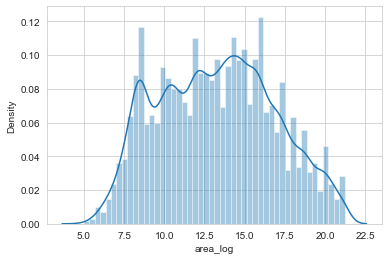

In [67]:
hist_a = train_data['area']
sn.set_style("whitegrid")
sn.distplot(hist_a)
plt.show()

train_data['area_log'] = np.sqrt(train_data['area'])
hist_alog = train_data['area_log']
sn.distplot(hist_alog)
plt.show()

test_data['area_log'] = np.sqrt(test_data['area'])

# Modify string variables

In [68]:
silhouette = []  #Empty list
l = ['latitud','longitud','estrato']
X = train_data[l].to_numpy()
#for n_clusters in range(5, 20):
#    kmeans = KMeans(n_clusters = n_clusters, random_state = 99,init='k-means++',algorithm = 'elkan')  #Implementation of K - MEANS
#    cluster_labels = kmeans.fit_predict(X)    #Predict the right cluster for each sample. 
#    score = silhouette_score(X, cluster_labels)  #Calculate the silhouette score. 
#    silhouette.append(score)  
#    print("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))

#plt.show()
#silhouette_fig, ax = plt.subplots()
#ax.plot(range(5,20), silhouette)
#ax.set_xlabel('Number of clusters')
#ax.set_ylabel('Silhouette score')
#ax.set_xticks(np.arange(5,20, 1.0))
#silhouette_fig.suptitle("Finding the right number of clusters", weight = 'bold', size = 18)

kmeans = KMeans(n_clusters = 10, random_state = 99,init='random')  #Implementation of K - MEANS
cluster_labels = kmeans.fit_predict(X)    #Predict the right cluster for each sample. 
score = silhouette_score(X, cluster_labels)
print(score)
train_data['cluster_labels'] = cluster_labels

0.9155010572019359


In [69]:
train_data['vista'] = train_data['vista'].replace(0,'Interior')
test_data['vista'] = test_data['vista'].replace(0,'Interior')
train_data['tiponegocio'] = train_data['tiponegocio'].replace('Venta y arriendo','Venta Y Arriendo')
train_data = train_data[train_data['tiponegocio'] != 'Arriendo']
train_data['tiempodeconstruido'] = train_data['tiempodeconstruido'].replace('ntre 0 y 5 años','Entre 0 y 5 años')
train_data['valor/m2'] = train_data['valorventa'] / train_data['area']
train_data['valor_habi'] = train_data['valor/m2']*0.95
train_data

,id,area,ascensor,balcon,banos,banoservicio,conjuntocerrado,cuartoservicio,deposito,estrato,...,valorventa,tipoinmueble,tiponegocio,latitud,longitud,valorventa_log,area_log,cluster_labels,valor/m2,valor_habi
137,149045,150.0,0.0,0.0,1.0,0.0,0,0.0,0.0,3.0,...,4.700000e+08,Casa,Venta,4.677140,-74.077888,19.968243,12.247449,3,3.133333e+06,2.976667e+06
138,252723,180.0,0.0,0.0,1.0,0.0,0,0.0,0.0,3.0,...,1.003000e+09,Casa,Venta Y Arriendo,4.704200,-74.101032,20.726261,13.416408,3,5.572222e+06,5.293611e+06
145,260959,313.0,0.0,0.0,1.0,0.0,0,0.0,0.0,3.0,...,1.100000e+09,Casa,Venta,4.745356,-74.046819,20.818576,17.691806,3,3.514377e+06,3.338658e+06
337,537063,360.0,0.0,0.0,1.0,0.0,0,0.0,0.0,4.0,...,2.110000e+09,Casa,Venta,4.664143,-74.108200,21.469954,18.973666,2,5.861111e+06,5.568056e+06
489,358081,450.0,0.0,0.0,1.0,0.0,0,0.0,0.0,5.0,...,1.650000e+09,Casa,Venta,4.693888,-74.063082,21.224041,21.213203,0,3.666667e+06,3.483333e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244483,6262941,235.0,0.0,0.0,4.0,0.0,0,1.0,0.0,4.0,...,8.056924e+08,Casa,Venta,4.737393,-74.038282,20.507213,15.329710,2,3.428478e+06,3.257054e+06
244484,6262942,225.0,0.0,0.0,4.0,0.0,0,1.0,0.0,4.0,...,7.509566e+08,Casa,Venta,4.734240,-74.038518,20.436858,15.000000,2,3.337585e+06,3.170706e+06
244485,6262943,235.0,0.0,0.0,4.0,0.0,0,1.0,0.0,4.0,...,7.525618e+08,Casa,Venta,4.736392,-74.040659,20.438994,15.329710,2,3.202391e+06,3.042271e+06
244486,6262944,232.0,0.0,0.0,4.0,0.0,0,1.0,0.0,4.0,...,7.049425e+08,Casa,Venta,4.737524,-74.040292,20.373627,15.231546,2,3.038545e+06,2.886618e+06


# Apply Ordinal Encoder to String columns

In [70]:
enc = OrdinalEncoder()

X_tn = train_data['tiponegocio'].to_numpy().reshape(len(train_data),1)
X_transform_tn = enc.fit_transform(X_tn)
train_data['tiponegocio_int'] = X_transform_tn

X_v = train_data['vista'].to_numpy().reshape(len(train_data),1)
X_transform_v = enc.fit_transform(X_v)
train_data['vista_int'] = X_transform_v

X_ti = train_data['tipoinmueble'].to_numpy().reshape(len(train_data),1)
X_transform_ti = enc.fit_transform(X_ti)
train_data['tipoinmueble_int'] = X_transform_ti

X_tc = train_data['tiempodeconstruido'].to_numpy().reshape(len(train_data),1)
X_transform_tc = enc.fit_transform(X_tc)
train_data['tiempodeconstruido_int'] = X_transform_tc

In [71]:
X_ttn = test_data['tiponegocio'].to_numpy().reshape(len(test_data),1)
X_transform_ttn = enc.fit_transform(X_ttn)
test_data['tiponegocio_int'] = X_transform_ttn

X_tv = test_data['vista'].to_numpy().reshape(len(test_data),1)
X_transform_tv = enc.fit_transform(X_tv)
test_data['vista_int'] = X_transform_tv

X_tti = test_data['tipoinmueble'].to_numpy().reshape(len(test_data),1)
X_transform_tti = enc.fit_transform(X_tti)
test_data['tipoinmueble_int'] = X_transform_tti

X_ttc = test_data['tiempodeconstruido'].to_numpy().reshape(len(test_data),1)
X_transform_ttc = enc.fit_transform(X_ttc)
test_data['tiempodeconstruido_int'] = X_transform_ttc

In [72]:
train_data_2 = train_data.select_dtypes(exclude = 'object')
test_data_2 = test_data.select_dtypes(exclude = 'object')
X_test_cluster = test_data[l].to_numpy()
cluster_labels_test = kmeans.predict(X_test_cluster)
test_data_2['cluster_labels'] = cluster_labels_test
train_data_2 = train_data_2.drop(columns = ['area','id','valorventa','latitud','longitud','estrato'])
test_data_2 = test_data_2.drop(columns = ['area','valorventa','latitud','longitud','estrato'])

<ipython-input-72-10b1fdb1e174>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_2['cluster_labels'] = cluster_labels_test


In [73]:
columns = train_data_2.columns.tolist()
train_columns = columns[:-6] + columns[-4:]
test_columns = columns[-5]
X = train_data_2[train_columns].to_numpy()
Y = train_data_2[test_columns].to_numpy()
Y = Y.reshape(Y.shape[0],)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=42)
#Linear regression model
reg = LinearRegression().fit(X_train, y_train)
Y_pred = reg.predict(X_test)
mape = mean_absolute_percentage_error(y_test,Y_pred)
print(mape)

0.13483995864013093


In [48]:
#gsc = GridSearchCV(
#    estimator=RandomForestRegressor(),   #Estimator used for grid search
#    param_grid={        
#        'n_estimators': (100,200,500,1000),
#        'max_depth': (5,10,15,None),
#        'min_samples_split': (2,3,5,10),
#    },   #Parameters of that estimator
#    cv=5, scoring='neg_mean_absolute_percentage_error', verbose=0,n_jobs=-1)   #Splitting value and metric for evaluation
    
#grid_result = gsc.fit(X_train, y_train)
best_params = grid_result.best_params_   #Best parameters after running grid search
    
rfr = RandomForestRegressor(n_estimators=best_params['n_estimators'],max_depth=best_params['max_depth'],
                            min_samples_split=best_params['min_samples_split'],random_state=1,n_jobs=-1)
                            #Best parameters usage for random forest
rfr.fit(X_train,y_train)
y_pred_r=rfr.predict(X_test)
print(mean_absolute_percentage_error(y_pred_r,y_test))
print(best_params)  

KeyError: 'min_samples_split'

In [74]:
#gsc = GridSearchCV(
#    estimator=GradientBoostingRegressor(),   #Estimator used for grid search
#    param_grid={        
#        "n_estimators":(100, 200, 500, 1000),
#        "max_depth": (5, 10, 15),
#        "learning_rate": (0.01, 0.05, 0.1),
#    },   #Parameters of that estimator
#    cv=5, scoring='neg_mean_absolute_percentage_error', verbose=0,n_jobs=-1)   #Splitting value and metric for evaluation
    
#grid_result = gsc.fit(X_train, y_train)
best_params = grid_result.best_params_   #Best parameters after running grid search
gbr = GradientBoostingRegressor(n_estimators=best_params['n_estimators'],max_depth=best_params['max_depth'],
                           learning_rate=best_params['learning_rate'],random_state=0)
                            #Best parameters usage for gradient boosting regressor
gbr.fit(X_train,y_train)
y_pred_gr=gbr.predict(X_test)
print(mean_absolute_percentage_error(y_pred_gr,y_test))
print(best_params)  

0.0046926762182315646
{'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 1000}


In [75]:
#Test model
columns_test = test_data_2.columns.tolist()
X_pred_cols = columns_test[1:]
X_pred = test_data_2[X_pred_cols].to_numpy()
Y_pred_test = reg.predict(X_pred)
test_data_2['valor_mt2_predicted'] = np.round(Y_pred_test.tolist(),3)
submission = pd.DataFrame()
submission['id'] = test_data_2['id']
submission['valormt2_predicted'] = test_data_2['valor_mt2_predicted']
submission.to_csv('submission.csv',index = False, decimal = '.',sep = ',')
submission

,id,valormt2_predicted
0,877392,1596704.661
1,201483,3732781.825
2,188674,3857150.406
3,1211067,3837703.069
4,883437,3847537.542
5,332550,3876149.384
6,320585,3847027.089
7,776969,3942409.633
8,435344,2043111.218
9,1274573,3819150.182


In [76]:
Y_pred_test_rf = rfr.predict(X_pred)
test_data_2['valor_mt2_predicted'] = np.round(Y_pred_test_rf.tolist(),3)
submission = pd.DataFrame()
submission['id'] = test_data_2['id']
submission['valormt2_predicted'] = test_data_2['valor_mt2_predicted']
submission.to_csv('submission_rf.csv',index = False, decimal = '.',sep = ',')
submission

,id,valormt2_predicted
0,877392,1704446.967
1,201483,3304505.233
2,188674,3306302.635
3,1211067,3410583.253
4,883437,3385029.303
5,332550,3363893.939
6,320585,3349947.735
7,776969,3407635.795
8,435344,1947906.457
9,1274573,3394125.987


In [77]:
Y_pred_test_gbr = gbr.predict(X_pred)
test_data_2['valor_mt2_predicted'] = np.round(Y_pred_test_gbr.tolist(),3)
submission = pd.DataFrame()
submission['id'] = test_data_2['id']
submission['valormt2_predicted'] = test_data_2['valor_mt2_predicted']
submission.to_csv('submission_gbr.csv',index = False, decimal = '.',sep = ',')
submission

,id,valormt2_predicted
0,877392,1724207.650
1,201483,3317754.089
2,188674,3319853.317
3,1211067,3411802.578
4,883437,3385873.400
5,332550,3379093.750
6,320585,3336300.716
7,776969,3422506.756
8,435344,1934205.322
9,1274573,3385751.648
